## Manifold Learning (Non-linear dimensionality reduction)

- Pros: Capture non-linear relationship between samples
- Cons: 
    - Not easy to handle missing data
    - Sensitive to noise contrary to PCA
    - Highly sensitive to the nb of neighbors chosen
    - Hard to determine the optimal nb of output dimension contrary to PCA
    - Meaning of embedded fimension hard to interprete
    - Learning is computationaly expensive (O(N'3)) contrary to PCA with randomized approach


- Descrive datasets as low-dimensional object embedded in high-dimensional spaces.
    - e.g. A sheet of paper in our 3D world. If you bend, curl, roll the paper, it is still a 2D object but the embedding into the 3D space is no longer linear.
    - e.g. A circle is a one-dimensional manifold embedded in two dimensions
    - e.g. The earth is a 2D manifold embedder in a 3D space


- **Objective:** Manifold Learning aims at learning about the fundamental 2D nature of the paper even as it is twisted to fill the 3D space
- The main idea here is that even though our real-world data is high-dimensional, there is actually some lower-dimensional representation. 


- Rarely used in practice except for visualization. First, explore the data with PCA, and then with Manifold 

In [82]:
%matplotlib inline
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm
sns.set_theme();

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


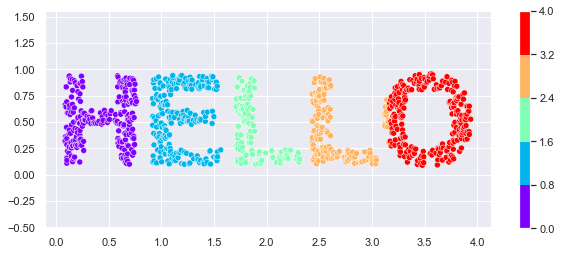

In [94]:
# Generate datapoints in the shape of "Hello"

def make_hello(N=1000, rseed = 42):
    
    fig, ax = plt.subplots(figsize=(4, 1))
    # Adjust the subplot layout parameter
    # The subplot fill the entire figure space
    fig.subplots_adjust(left = 0,
                        right = 1, # The position of the subplot right edge as a fraction of the figure width
                        bottom = 0,
                        top = 1)
    
    # Plot the text
    ax.axis("off") # Turn off axis lines and labels
    ax.text(0.5, # x-coordonate in the data coordonate not axis coordonate
            0.4, # y-coordonate in the data coordonate not axis coordonate
            "HELLO", # Text to display
            va = 'center', # Vertical allignment
            ha = 'center', # Horizontal alligment
            weight = 'bold', # FontWeight
            size = 85 # character size
           )
    # Save the plot & close the current figure window
    fig.savefig("hello.png")
    plt.close(fig)
    
    # Open the plot and draw random points form it
    from matplotlib.image import imread # Module to read an image from a file into an array
    data = imread("hello.png") # Shape is (X, Y, 4) for RGBA images ->(72, 288, 4) because weight = 4*height
    data = data[::-1, :, 0] # Reverse the datapoints and arbitrarly extract the 'red' values from RGBA -> (72, 288)
    data = data.T # Inverse x and y axis -> (288, 72)
    
    # Generate random sample of N datapoints
    rng = np.random.RandomState(rseed)
    X = rng.rand(4*N, 2) # Create array of the given shape (4*N, 2) -> (4'000, 2)
                         # an populate it with random sample from uniform distribution over [0, 1]
    # (X * data.shape) remains (4'000,  2)
    # (X * data.shape).astype(int).T becomes (2, 4'000)
    i, j = (X * data.shape).astype(int).T # Scale the X-[0, 1] dist. to [0, 288] and the Y-[0, 1] dist. to [0, 72]
    # i has shape (4'000,) with random integer values in [0, 288]
    # j has shape (4'000,) with random integer values in [0, 72]
    # data contains values in [0, 1]
    mask = (data[i, j] < 1) # Generate a mask (4000,) with mask_n = True if data[i_n, j_n] < 1
    X = X[mask] # Keep only a subset of points, here (4'000, 2) -> (1'532, 2).
                # Make sure 1'532 > 1'000 by using a factor 4
    X[:, 0] *= (data.shape[0] / data.shape[1]) # Scale up the X-[0, 1] value to [0, 4] to match figure size
    X = X[:N] # Keep only 1'000 samples. X has shape (1'000, 2)
    return X[np.argsort(X[:, 0])] # Sort X by x-coordonate in increasing order
    
X = make_hello(1000)
colorize = {"c": X[:, 0], # X[:, 0] goes from 0 to 4, 
            "cmap": plt.cm.get_cmap("rainbow", 5)} # Resample color map with 5 entires, one for each letter

fig, ax = plt.subplots(figsize=(10, 4))
ax = sns.scatterplot(X[:, 0], X[:, 1], **colorize)
# Create the color bar
sm = matplotlib.cm.ScalarMappable(cmap=plt.cm.get_cmap("rainbow", 5)) # Create a ScalarMappable from the Colormap
sm.set_array(np.arange(5))
c_bar = ax.figure.colorbar(sm)
c_bar.set_ticks(np.linspace(0,4,6))

ax.axis('equal');


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


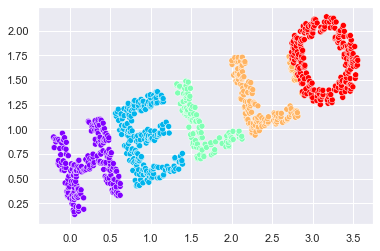

In [99]:
## Multidimensional Scaling (MDS): Motivation

# The particular choice of y and y are not the most fundamental descrption of the data.
# Any affine transformation would still make "HELLO" apparent -> PCA would perform badly

def rotate(X, angle):
    theta = np.deg2rad(angle) # Convert frm degree to radians
    # Define rotation matrix
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)

X2 = rotate(X, 20)
sns.scatterplot(X2[:, 0], X2[:, 1], **colorize)

# x and y values are not fundamental to the relationshup in the data
# What is fundamental is the distance between each point and the other points in the dataset
# Let's use the 'distance matrix': Matrix of size (n_samples, n_samples)

from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)

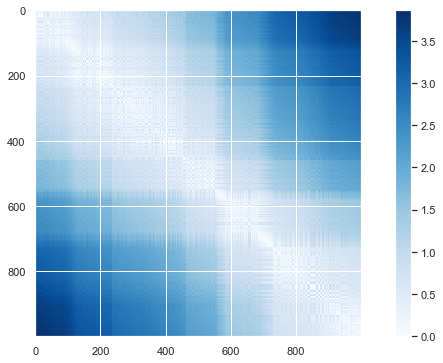

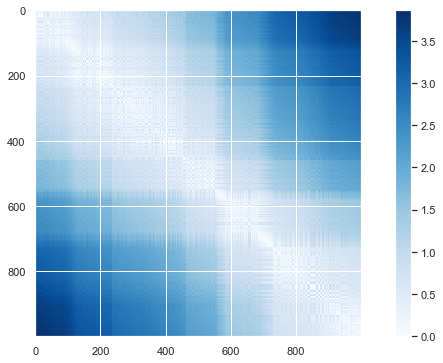

In [114]:
# Plot the distance matrix:
fig, ax = plt.subplots(figsize=(12, 6))
ax = ax.imshow(D, cmap = 'Blues', interpolation = 'nearest')
fig.colorbar(ax)

# X is sorted in x-coordonate increasing order, so the further 2 points are in X (e.g. X[0] and X[900]),
# the larger the distance tend to be

# We can see a pattern, but:
# - We have lost any visible sign of the "HELLO" sign
# - How to transform back the distance into x and y coordonate


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-1.029149779948386, 1.027856768171946, -2.04948940500963, 2.1202816440434114)

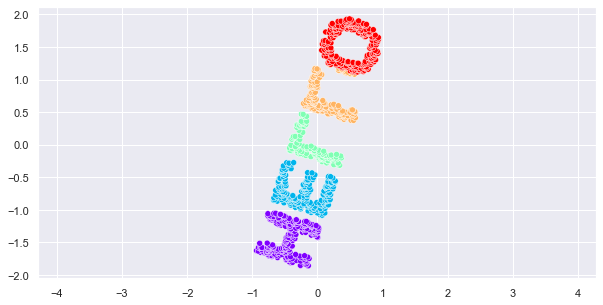

In [130]:
# MSC = Multidimensional scaling
# The MSC is trying to transform back the distance matrix into a N-Dimensional coordonates system

from sklearn.manifold import MDS
model = MDS(n_components=2, # Number of dimensions in which to immerse the dissimilarities
            dissimilarity='precomputed', # Specify that we are passing a distance matrix
            random_state = 1)
X_model = model.fit_transform(D)

# Plot the recoved dataset
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(X_model[:, 0], X_model[:, 1], **colorize)
ax.axis('equal')

# MDS recovers one of possible 2D coordinate representation of our data
# Note that distance matrices can be computed from data in any dimension

X shape: (1000, 2)
e shape: (3,)
V shape: (3, 3)

X3 shape: (1000, 3)


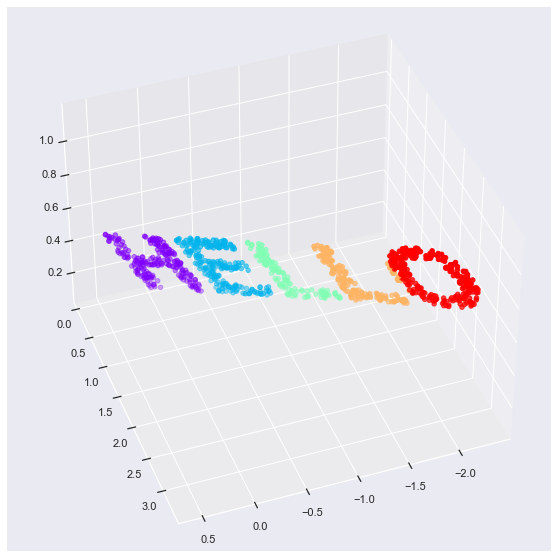

In [154]:
## MDS as Dimensionality reduction

# Let define our "HELLO" text in 3D
def random_project(X, dim=3, rseed=42):
    assert dim >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dim, dim) # Matrix drawn from Normal dist of shape (dim, dim)
    e, V = np.linalg.eigh(np.dot(C, C.T)) # Get the eigenvalues and eigenvectors of C^2
    print(f"X shape: {X.shape}")
    print(f"e shape: {e.shape}")
    print(f"V shape: {V.shape}\n")
    return np.dot(X, V[:X.shape[1]]) # Project X into 3D space

X3 = random_project(X, 3)
print(f"X3 shape: {X3.shape}")

# Vizualize the the dataset in 3D
from mpl_toolkits import mplot3d

ax = plt.axes(projection='3d')
ax.figure.set_size_inches(10, 10)
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2], **colorize)
ax.view_init(azim = 70, # Horizontal angle
             elev = 40 # Vertial angle
            )

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


(-1.029149779948385,
 1.0278567681719433,
 -2.0494894050096297,
 2.1202816440434136)

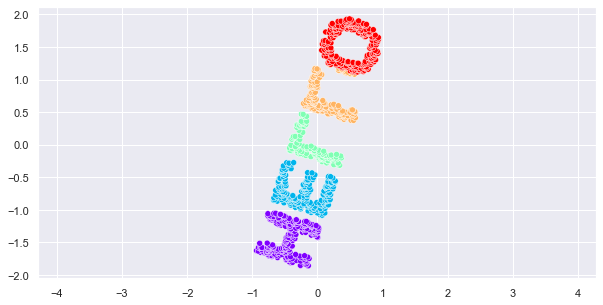

In [160]:
# MDS from 3D to 2D

# MDS will compute the distance matrix and determine the optimal 2D embedding for this distance matrix
model = MDS(n_components=2,
            random_state=1)
X_model = model.fit_transform(X3)

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(X_model[:, 0], X_model[:, 1], **colorize)
ax.axis('equal')

# MDS: Perserve the distance relationship between every pair of points


Final shape: (1000, 3)


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


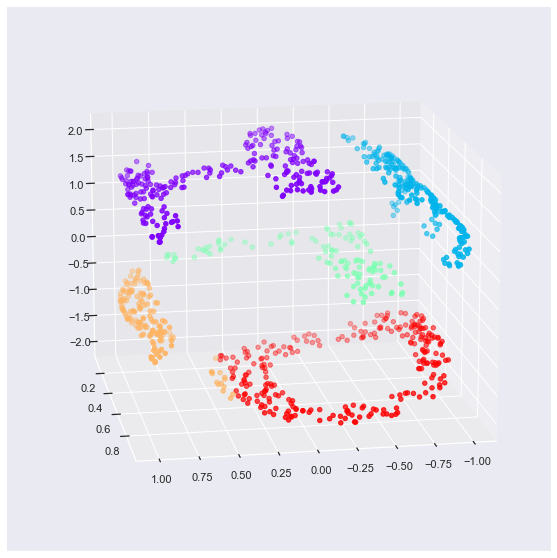

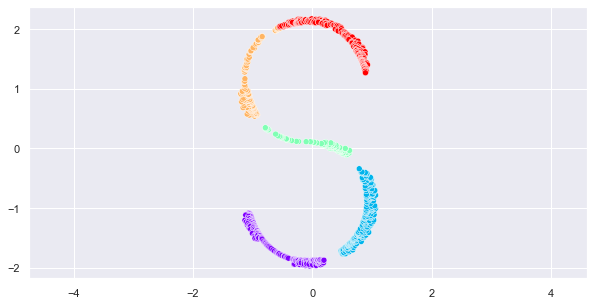

In [236]:
# MDS drawback

# Project our 2D "HELLO" in a non-linear way into a 3D space
def make_hello_s_curve(X):
    # Twist the x-coordonates
    t = (X[:, 0] - 2)*0.75*np.pi
    x = np.sin(t)
    # Keep the y-coordonate
    y = X[:, 1]
    # Define z-coordonate
    # np.sign return 1 if elem > 0, 1 if elem == 0, -1 o.w.
    z = np.sign(t) * (np.cos(t) - 1)
    X_curve = np.vstack((x, y, z)).T
    print(f"Final shape: {X_curve.shape}")
    return X_curve

X_curve = make_hello_s_curve(X)


# Let's plot our twisted "HELLO"
ax = plt.axes(projection="3d")
ax.figure.set_size_inches(10, 10)
ax.view_init(azim = 80, # Horizontal angle
             elev = 15 # Vertial angle
            )
ax.scatter3D(X_curve[:, 0], X_curve[:, 1], X_curve[:, 2], **colorize)

# Let's try to reduce X_curve into 2D space with MDS
model = MDS(n_components=2,
            random_state=1)
X_model = model.fit_transform(X_curve)

fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(X_model[:, 0], X_model[:, 1], **colorize)
ax.axis('equal');

# -> The best 2D LINEAR embeing does not undo the X-curve

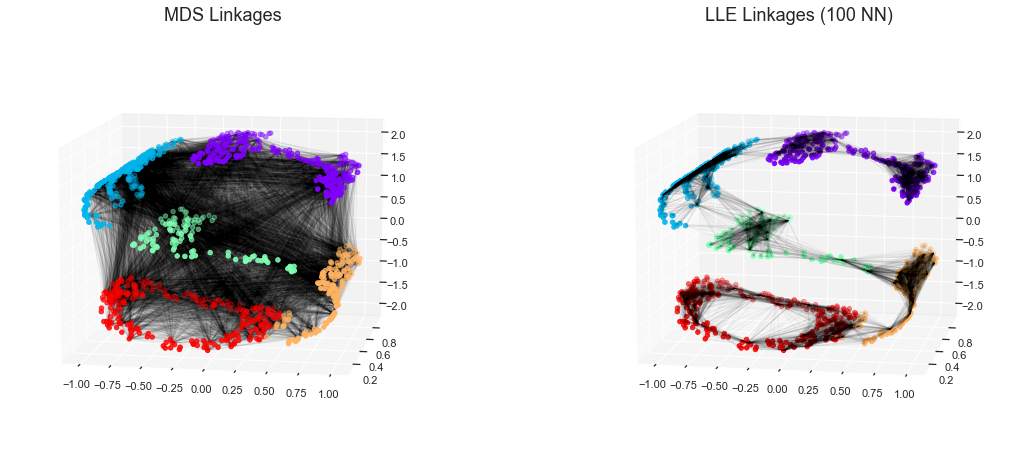

In [237]:
## Non-linear Manifold
# LLE (Locally Linear Embedding)

# Problem of MDS with non-linear relationship is that MDS tries to globally preserve distance, even between
# faraway points. What if the distance are preserved LOCALLY only ? 

from mpl_toolkits.mplot3d.art3d import Line3DCollection
from sklearn.neighbors import NearestNeighbors

# Construct lines for MDS
rng = np.random.RandomState(42)
# Randomly permute a sequence. ind has shape (1000,) each element correspond to an index in X
ind = rng.permutation(len(X)) 
# Do not draw all lines for visibily purpose. Take only the 100 first and 100 second data points
lines_MDS = [(X_curve[i], X_curve[j]) for i in ind[:100] for j in ind[100:200]] # Shape = (10'000) of tuples

# construct lines for LLE
# For each point, take only the 100 closest points
# kneighbors() = Get the 100 neighbors of a point. Return distance, indices of nearest points. Discard distance
nbrs = NearestNeighbors(n_neighbors=100).fit(X_curve).kneighbors(X_curve[ind[:100]])[1] # Shape is (100, 100)
lines_LLE = [(X_curve[ind[i]], X_curve[j]) for i in range(100) for j in nbrs[i]]
titles = ['MDS Linkages', 'LLE Linkages (100 NN)']

# plot the results
fig, ax = plt.subplots(1, 2, figsize=(16, 6),
                       subplot_kw=dict(projection='3d', facecolor='none'))
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0, wspace=0)

for axi, title, lines in zip(ax, titles, [lines_MDS, lines_LLE]):
    # Plot points
    axi.scatter3D(X_curve[:, 0], X_curve[:, 1], X_curve[:, 2], **colorize);
    # Plot lines
    axi.add_collection(Line3DCollection(lines, lw=1, color='black',
                                        alpha=0.05))
    axi.view_init(elev=10, azim=-80)
    axi.set_title(title, size=18)

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

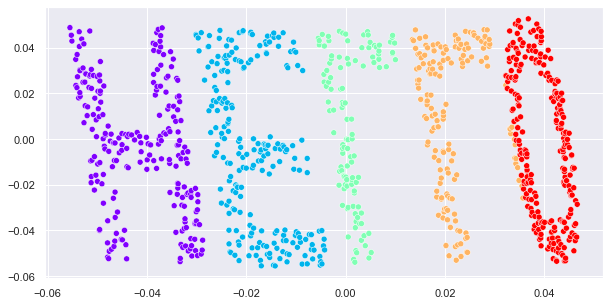

In [242]:
# LLE (Modified LLE = One type of LLE algorithm)
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors = 100, # Define what neighborhood means: 100 closest datapoints
                               n_components = 2, # 2D reduction
                               method='modified', # Type of LLE to use
                               eigen_solver='dense' # Use standard dense matrix operation for eigenvalue decomposition
                                                    # Warning: Avoid 'dense' for large problems
                               )
X_model = model.fit_transform(X_curve)

fig, ax = plt.subplots(figsize = (10, 5))
sns.scatterplot(X_model[:, 0], X_model[:, 1], ** colorize)

# -> Essential relationship is preserved

Face data shape: (2370, 2914)
Face images shape: (2370, 62, 47)


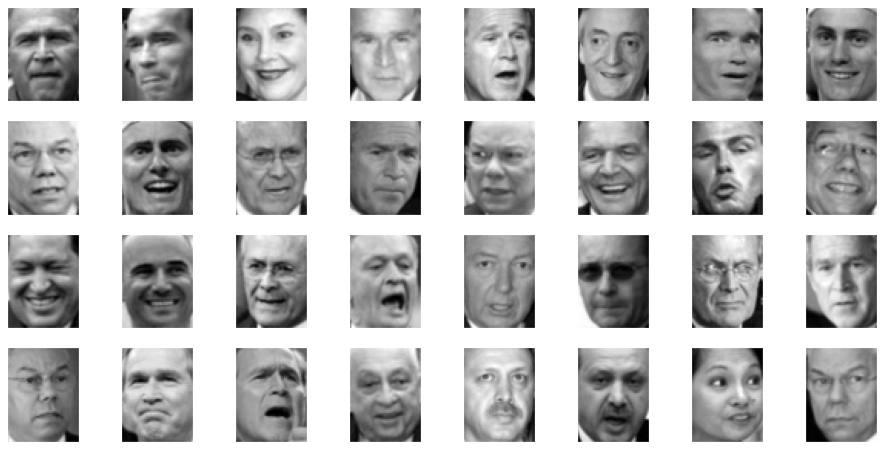

In [252]:
## Example Manifold: Isomap (Non-linear)
# Tend to perform better than LLE on real-world data.

# Get a high-dimensional dataset: faces
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
print(f"Face data shape: {faces.data.shape}") # n_sample = 2'370, nb_features = 2'914
print(f"Face images shape: {faces.images.shape}") # original image size = 62 x 47

# Plot a sample of faces
fig, axes = plt.subplots(4, 8,
                         figsize=(16, 8),
                         subplot_kw={"xticks": [], # Remove ticks to display images
                                     "yticks": []})
for idx, ax in enumerate(axes.flat):
    ax.imshow(faces.images[idx], cmap='gray')

Original data shape: (2370, 2914)
Projected data shape: (2370, 100)


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Isomap projected data shape: (2370, 2)


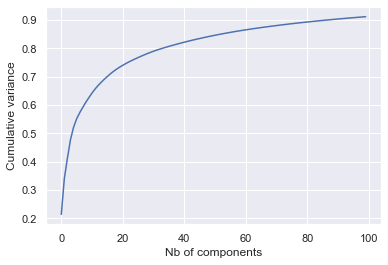

In [274]:
# Goal : Plot a low-dimensional embedding of the 2'914-dimensional data

# 1. With PCA: How many linear features are required to describe the data
from sklearn.decomposition import PCA
model = PCA(n_components=100,
            svd_solver='randomized' # Approx. Singular Value Decomposition
           )
X_model = model.fit_transform(faces.data)
print(f"Original data shape: {faces.data.shape}")
print(f"Projected data shape: {X_model.shape}")

ax = sns.lineplot(np.arange(100), np.cumsum(model.explained_variance_ratio_))
ax.set_xlabel("Nb of components")
ax.set_ylabel("Cumulative variance")
# -> ~90 linear features are enought to retain 90% of the variance

# 2. With Non-linear manifold: Isomap
from sklearn.manifold import Isomap
model = Isomap(n_components = 2)
X_model_isomap = model.fit_transform(faces.data)
print(f"Isomap projected data shape: {X_model_isomap.shape}")

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


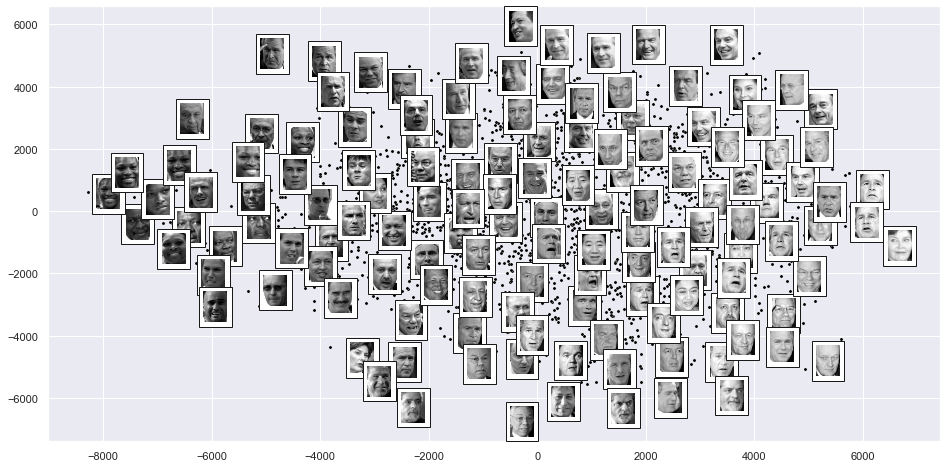

In [301]:
# Plot faces thumbnails at the locations of the projection
from matplotlib import offsetbox

def plot_components(data, model, images, ax=None, thumb_frac=0.05, cmap='gray'):
    # Get the current Axes or create one if necessary
    ax = ax or plt.gca()
    
    # Train the model & get the 2D reduction plan
    X_model = model.fit_transform(data)
    # Mark each picture with a dot
    sns.scatterplot(X_model[:, 0], X_model[:, 1], color = 'black', s = 10, ax=ax)
    
    if images is not None:
        d_max = X_model.max(0) # Maximal value for each coordonate. Shape is nb_features
        d_min = X_model.min(0) # Minimal value for each coordonate. Shape is nb_features
        # Define minimal distance threshold below which images is not displayed
        largest_d_spread = max(d_max - d_min)
        min_dist_2 = (thumb_frac*largest_d_spread)**2

        shown_images = np.array([2*X_model.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((X_model[i] - shown_images)**2, 1)
            if np.min(dist) < min_dist_2:
                # Don't show the points that are too close for visibility
                continue
            shown_images = np.vstack([shown_images, X_model[i]])
            imagebox = offsetbox.AnnotationBbox( # Container for an OffsetBox
                offsetbox.OffsetImage(images[i], cmap=cmap), X_model[i])
            ax.add_artist(imagebox)
    
fig, ax = plt.subplots(figsize=(16, 8))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2] # Truncate images features for running time purpose
               )

# Observations: 
# X coordonate represents the darkness
# Y coordonate represent the orientation of the face

Data shape: (70000, 784)


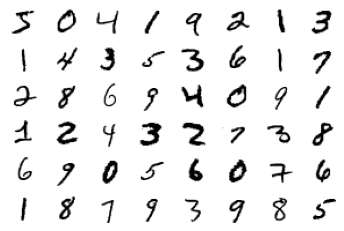

In [327]:
# Example n°2: Isomap

from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=False)
print(f"Data shape: {mnist.data.shape}") # 70'000 samples, 784 features. Size of an image: 28 x 28

# Visualize the first images
fig, axes = plt.subplots(6, 8, subplot_kw={"xticks": [],
                                           "yticks": []})
for i, ax in enumerate(axes.flat):
    ax.imshow(mnist.data[i].reshape(28, 28), cmap='gray_r')

Projected data shape: (2334, 2)


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:>

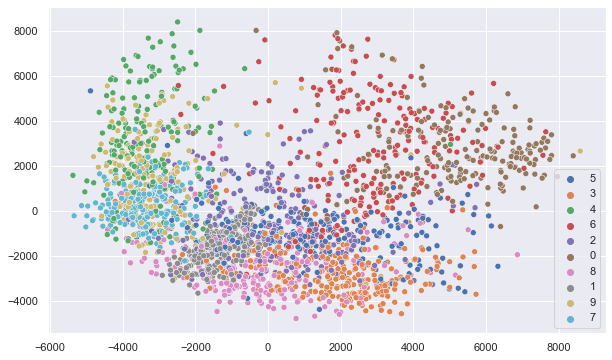

In [330]:
# Train Isomap model on handwriting dataset
# For speed purpose, let's use 1/30 of the samples only

data = mnist.data[::30] # data has shape (2'334, 784)
target = mnist.target[::30] # target has shape (2'334)

model = Isomap(n_components=2)
data_model = model.fit_transform(data)
print(f"Projected data shape: {data_model.shape}")

# Plot the projected data
fig, ax = plt.subplots(figsize = (10, 6))
sns.scatterplot(data_model[:, 0], data_model[:, 1], hue=target)

# Plot is too crowded, let's look at a single number at a time

In [338]:
mask = mnist.target == "1"
data = mnist.data[mask][::4]


In [342]:
data.reshape((data.shape[0], 28, 28)).shape

(1970, 28, 28)

Shape of data: (1970, 784)


/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


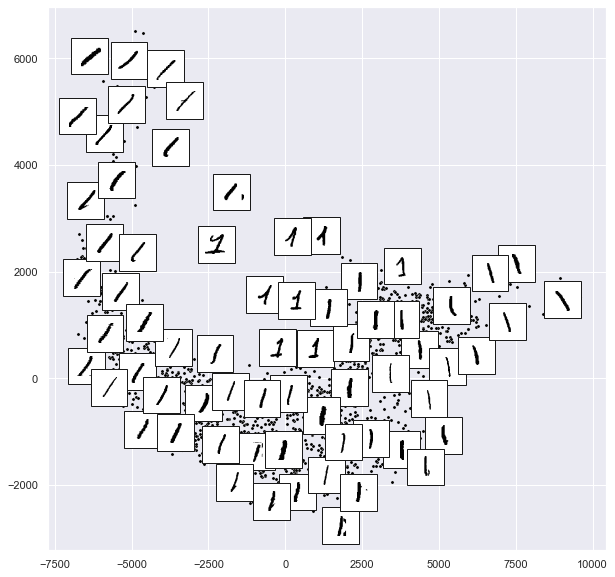

In [347]:
# Train Isomap on digit = 1 only

# For speed purpose take 1/4 only
mask = mnist.target == "1"
data = mnist.data[mask][::4]
print(f"Shape of data: {data.shape}")

fig, ax = plt.subplots(figsize=(10, 10))
model = Isomap(n_neighbors=5, # Distance preserved for the 5 closest points only
               n_components=2,
               eigen_solver='dense'
               )
plot_components(data,
                model=model,
                images=data.reshape((data.shape[0], 28, 28)), # Truncate images features for running time purpose
                cmap='gray_r' # reverse
               )

# The curve describes the angle of inclination
# Small cluster for 1s that have hat or bases
# Weird outliers at top-left corver

/Users/nicolas/anaconda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


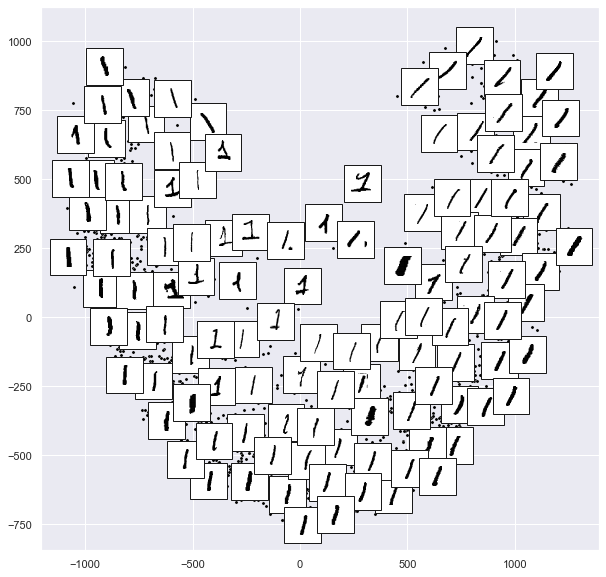

In [360]:
# Train PCA on digit = 1 only

# For speed purpose take 1/4 only
mask = mnist.target == "1"
data = mnist.data[mask][::4]

fig, ax = plt.subplots(figsize=(10, 10))
from sklearn.decomposition import PCA
pca = PCA(n_components= 2,
          svd_solver='randomized', # Approx. Singular Value Decomposition
          )
plot_components(data,
                model=pca,
                images=data.reshape((data.shape[0], 28, 28)), # Truncate images features for running time purpose
                cmap='gray_r' # reverse
               )

#### Concepts summary

- Manifold Learning: Learn the fundamental low-dimension nature of observations embedded in high-dimension space.
    - Linear Manifold
        - **MDS**: Multidimensional scaling: Based on a **global distance** matrix, look for the best low-dimensial representation of the data
            - Pros: Preserve distance between each points
            - Cons: Fail to capture non-linear relationship
    - Non Linear Manifold
        - **LLE**: Based on a **neighbors distance** matrix, look for the best low-dimensial representation of the data
            - Pros: Preserve the distance between neighbors points only -> Capture non-linear relationship
        - **Isomap**: Similar as LLE but tend to perform better on real-world dataset
        
        
- Manifold vs. PCA:
    - Manifold learning attempts to generalize PCA to perform dimensionality reduction on all sorts of dataset structures, with the main idea that manifolds, or curved, continuous surfaces, should be modelled by preserving and prioritizing LOCAL over global distance.
        
- MDS vs PCA ?
    - MDS minimizes dimension, preserving distance between datapoints
    - PCA minimizes dimension, preserving covariance of data